# Neural Network Regression for Depth Thermography

In [462]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import random
%matplotlib inline

In [463]:
# Parameters for Neural Network
args = {'lr':0.01,
        'train epochs':5000,
        'noise':0.01,
        'train size':0.7,
        'spec scale':10**12,
        'train criterion':nn.L1Loss(),
        'test criterion':nn.L1Loss(),
        'scaler':RobustScaler()
        }

## Data Prepocessing

In [464]:
# read data
df = pd.read_excel('data_3nm.xlsx')

In [465]:
# spectrum data
X = df.iloc[:,11:]

# layer data
y = df.iloc[:,:11]

In [466]:
# multiply by 10^12 to get values closer to 1
X = X.apply(lambda x: x*args['spec scale'])

In [467]:
# function to add noise as a percentage 
def add_noise(data, percentage):
    std_dev = percentage * (10**-12) * (args['spec scale'])
    noise = np.random.normal(0, std_dev, data.shape)
    noisy_data = data + noise
    return noisy_data

In [468]:
# add noise
X_noisy = add_noise(X, args['noise'])

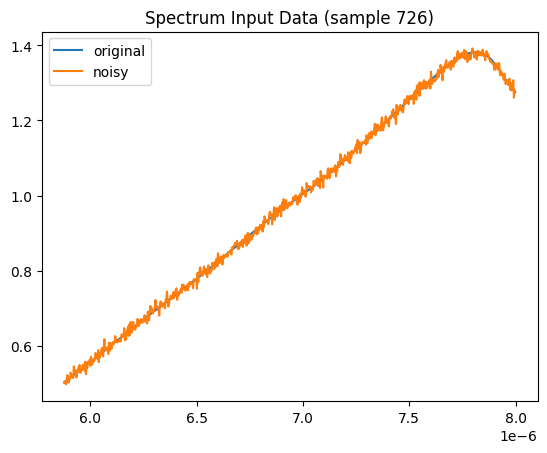

In [469]:
# plot the difference between noisy and original data
entry = random.randint(0, len(X))
plt.title(f'Spectrum Input Data (sample {entry})')
plt.plot(X.iloc[entry][-int(len(X.iloc[entry])*.5):], label='original')
plt.plot(X_noisy.iloc[entry][-int(len(X.iloc[entry])*.5):], label='noisy')
plt.legend()
plt.show()

In [470]:
# scale the input data
scaler = args['scaler']
X_noisy_scaled = scaler.fit_transform(X_noisy)

X_noisy_scaled_df = pd.DataFrame(X_noisy_scaled, columns=X.columns)

In [471]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_noisy_scaled_df, y, train_size=args['train size'], random_state=69)

In [472]:
# convert data to tensors for model
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

## Neural Network Setup

In [473]:
# define neural network
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.lin_input = nn.Linear(input_size, 30)
        self.hidden1 = nn.Linear(30, 15)
        self.lin_output = nn.Linear(15, output_size)

    def forward(self, x):
        x = F.relu(self.lin_input(x))
        x = F.relu(self.hidden1(x))
        x = self.lin_output(x)
        return x

In [474]:
# define loss function
criterion = args['train criterion']

# instantiate model
model = Net(X_train_tensor.size()[1], y_train_tensor.size()[1])

# define optimizer
optimizer = torch.optim.Rprop(model.parameters(), lr=args['lr'])

print(model)

Net(
  (lin_input): Linear(in_features=1417, out_features=30, bias=True)
  (hidden1): Linear(in_features=30, out_features=15, bias=True)
  (lin_output): Linear(in_features=15, out_features=11, bias=True)
)


## Neural Network Training Loop

In [475]:
best_loss = np.inf
best_epoch = 0
train_losses = []
valid_losses = []

print('epoch'.ljust(6) + '| train loss'.ljust(14) + '| valid loss' + '\n---------------------------------')

for epoch in range(args['train epochs']):
    # forward pass
    outputs = model(X_train_tensor)

    # get loss
    loss = criterion(outputs, y_train_tensor)

    # update and backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # add losses to the list for tracking
    train_losses.append(loss.item())
    
    # check if it is the best loss
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_epoch = epoch+1

    # get validation loss
    valid_pred = model(X_test_tensor)
    valid_loss = criterion(valid_pred, y_test_tensor)
    valid_losses.append(valid_loss.item())

    if (epoch+1) % int(args['train epochs']/10) == 0:
        print(f'{epoch+1}'.ljust(6) + f'|   {loss:.4f}'.ljust(14) + f'|   {valid_loss.item():.4f}')

print(f'\nbest training loss: {best_loss:.3f} in epoch {best_epoch}\n')  

epoch | train loss  | valid loss
---------------------------------
500   |   4.2587    |   4.9681
1000  |   3.5189    |   4.3807
1500  |   3.3856    |   4.2970
2000  |   3.3624    |   4.2849
2500  |   3.3595    |   4.2835
3000  |   3.3586    |   4.2830
3500  |   3.3582    |   4.2827
4000  |   3.3577    |   4.2825
4500  |   3.3573    |   4.2823
5000  |   3.3569    |   4.2820

best training loss: 3.357 in epoch 4999



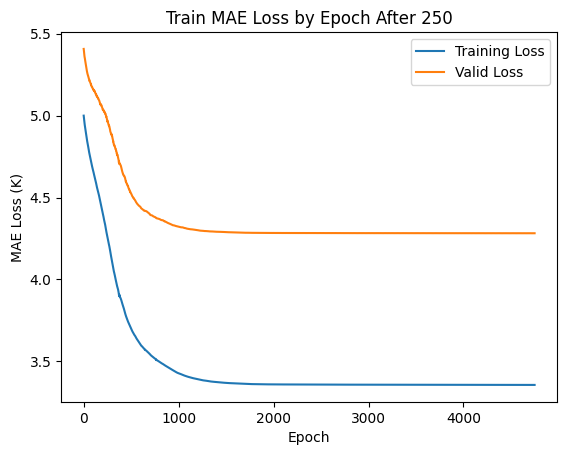

In [476]:
# plot loss over epochs
plt.plot(train_losses[250:], label='Training Loss')
plt.plot(valid_losses[250:], label='Valid Loss')

    
plt.title("Train MAE Loss by Epoch After 250")
plt.xlabel("Epoch")
plt.ylabel("MAE Loss (K)")
plt.legend()
plt.show()

## Model Testing

In [477]:
# test model on validation data
test_criterion = args['test criterion']
test_losses = []

print('Test Losses')
with torch.no_grad():
    model.eval()

    # overall predictions and loss
    pred = model(X_test_tensor)
    loss = test_criterion(pred, y_test_tensor)

    print(f'Overall: {loss.item()}\n')

    # per layer loss based on previous predictions
    pred_layers = []
    for i in range(pred.size(1)):
        column = pred[:, i]
        pred_layers.append(column)

    actual_layers = []
    for i in range(y_test_tensor.size(1)):
        column = y_test_tensor[:, i]
        actual_layers.append(column)

    for i in range(y_test_tensor.size(1)):
        loss = test_criterion(pred_layers[i], actual_layers[i])
        test_losses.append(loss.item())
        print(f'Layer {i+1}: {loss.item()}')

#print(test_losses)

Test Losses
Overall: 4.282049655914307

Layer 1: 3.956899881362915
Layer 2: 7.666402339935303
Layer 3: 4.209992408752441
Layer 4: 4.188897132873535
Layer 5: 4.802149772644043
Layer 6: 4.627631187438965
Layer 7: 5.198180675506592
Layer 8: 3.635759115219116
Layer 9: 3.895848035812378
Layer 10: 3.600619316101074
Layer 11: 1.3201704025268555


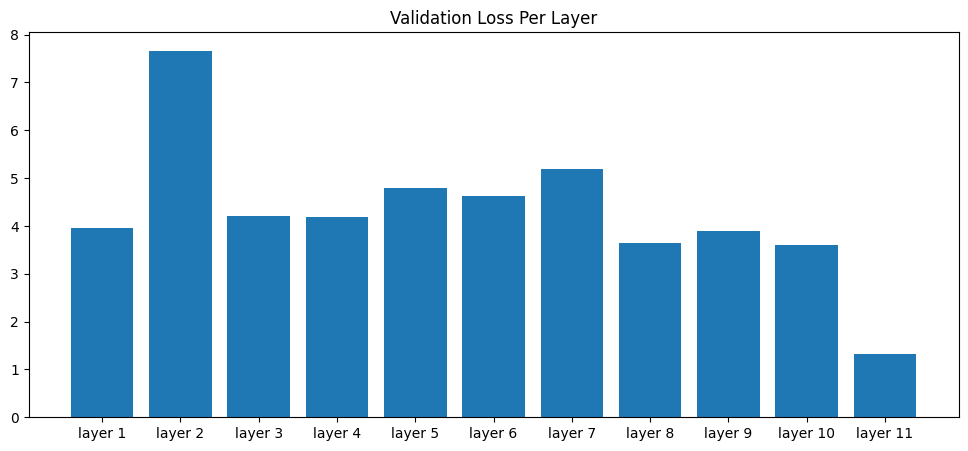

In [478]:
# plot losses
plt.figure(figsize=(12,5))
plt.title('Validation Loss Per Layer')
plt.bar(y.columns, test_losses)
plt.show()

## Prediction Visualization

In [479]:
# put predictions into dataframe for comparison
pred_df = pd.DataFrame(pred.numpy())

In [480]:
# function to plot comparison between predicted and actual values from a given sample
def plot_comparison(pred, actual, sample):
    plt.figure(figsize=(15, 5))
    plt.title(f"Temperature Across Layers for Sample {sample}")
    plt.xlabel("Layer")
    plt.ylabel("Temperature (K)")
    plt.plot(pred, 'ro', label='predicted')
    plt.plot(actual, 'b', label='actual')
    plt.legend()
    plt.show()

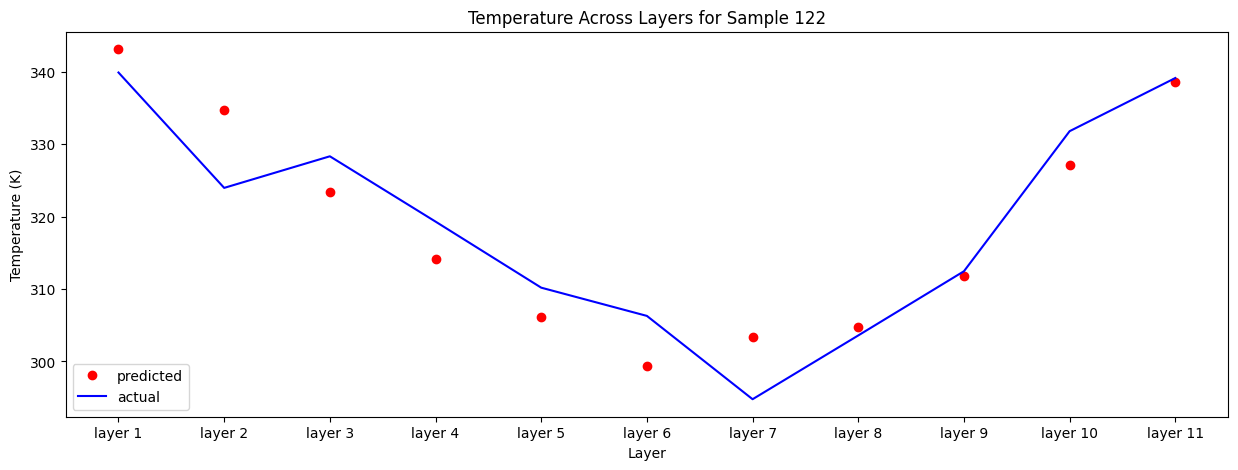

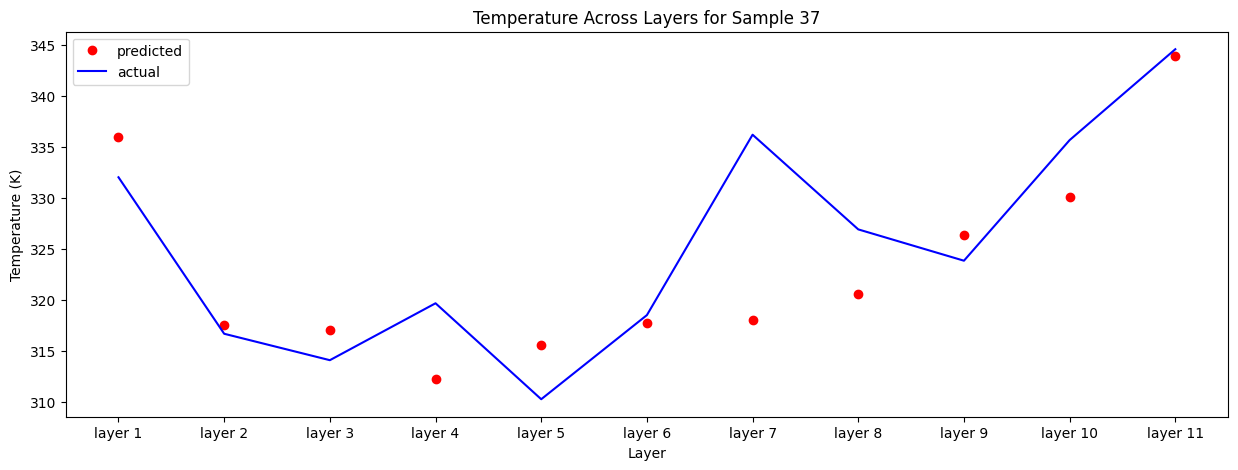

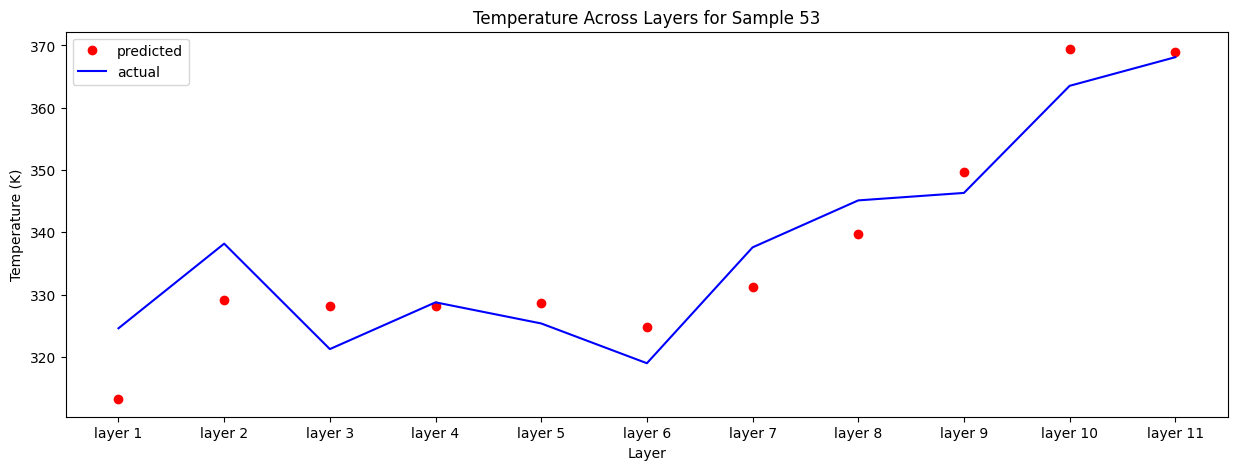

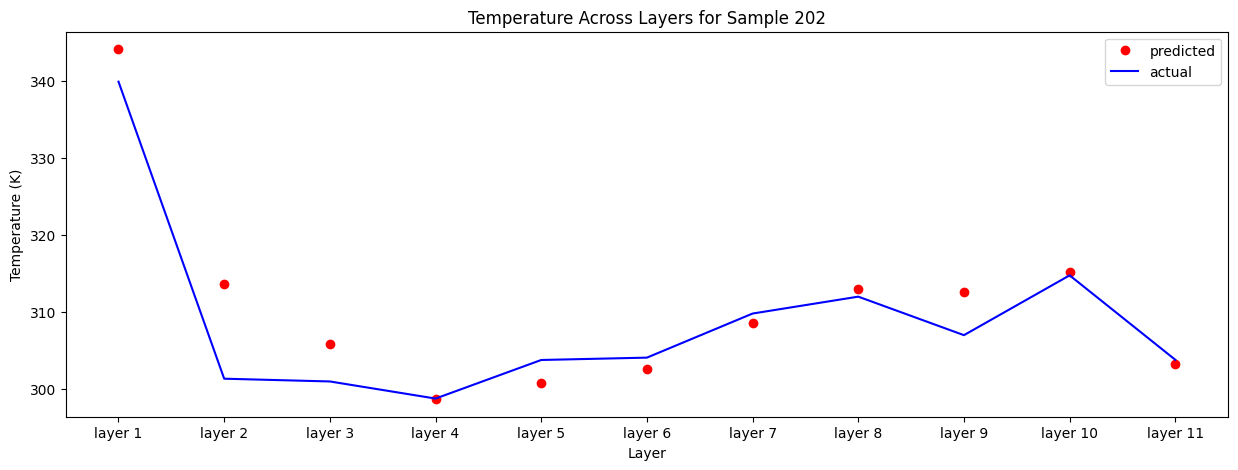

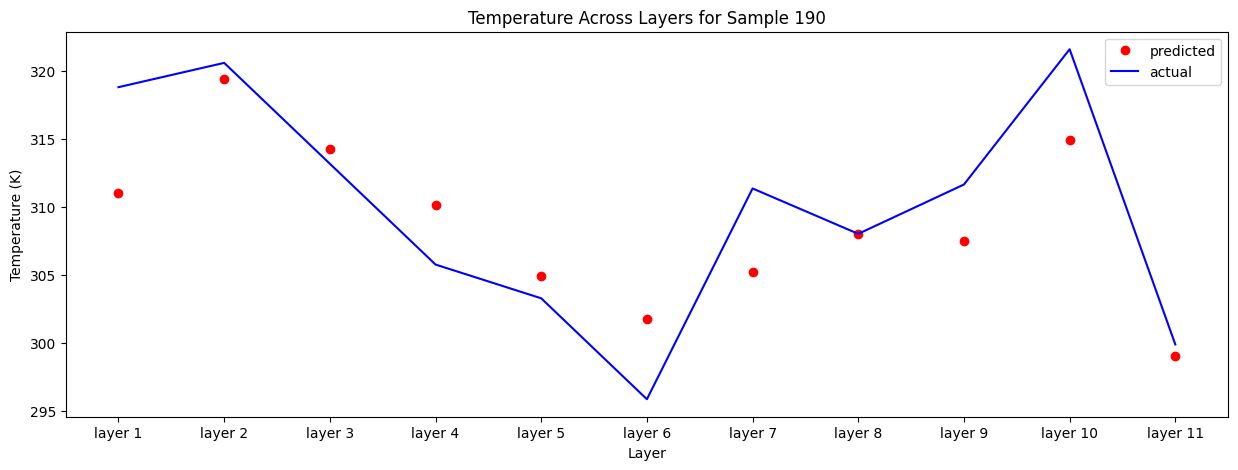

In [481]:
# pick 5 random indices from the dataset and plot the comparison between predicted and actual values
indices = []
for i in range(0,5):
    n = random.randint(0, len(y_test))
    indices.append(n)

for i in indices:
    a = y_test.iloc[i,:]
    p = pred_df.iloc[i,:]

    plot_comparison(p, a, i)